In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import numpy as np

np.set_printoptions(precision=2, floatmode='fixed')

import tsvar

In [7]:
print('  - Define model parameters...')
# Define random parameters
dim = 2  # Dimensionality of the process
end_time = 2e4  # Choose a long observation window
mu = torch.tensor([0.3, 0.1])
beta = torch.tensor([1.0, 0.1])
alpha = torch.tensor([
    [0.7, 0.3],
    [0.0, 1.0]
])
coeffs_true = torch.cat((mu, beta.flatten(), alpha.flatten())).numpy()
print('  - Simulate lots of data...')
# Simulate lots of data
wold_sim = tsvar.simulate.GrangerBuscaSimulator(
    mu_rates=mu, Alpha_ba=alpha, Beta_b=beta)
events = wold_sim.simulate(end_time, seed=4243)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]
print((f"    - Simulated {sum(map(len, events)):,d} events "
       f"with end time: {end_time}"))


  - Define model parameters...
  - Simulate lots of data...
    - Simulated 21,890 events with end time: 20000.0


In [8]:
print('  - Run MLE...')
# Define model
model = tsvar.models.WoldModelMLE(verbose=True)
model.observe(events, end_time)

coeffs_start = torch.cat((
    0.50 * torch.ones(dim, dtype=torch.float),
    0.01 * torch.ones(dim, dtype=torch.float).flatten(),
    0.50 * torch.ones((dim, dim), dtype=torch.float).flatten()
))

callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    coeffs_start, coeffs_true, print_every=10)

conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=0.05,
                 lr_sched=0.9999, tol=1e-5, max_iter=1000,
                 penalty=tsvar.priors.GaussianPrior, C=1e10,
                 seed=None, callback=callback)
coeffs_hat = model.coeffs.detach().numpy()

print('\nConverged?', conv)
max_diff = np.max(np.abs(coeffs_true - coeffs_hat))
print(f'  - coeffs_hat:  {coeffs_hat.round(2)}')
print(f'  - coeffs_true: {coeffs_true.round(2)}')
print(f'  - max_diff: {max_diff:.4f}')
assert max_diff < 0.1, 'Test FAILED !!!'
print('  - Test SUCESS! (max_diff < 0.1)')

  - Run MLE...
iter:  1000 | dx: 5.9640e-04 | loss: 1.5605e+00 |  time per iter: 3.58e-03    
Converged? None
  - coeffs_hat:  [0.31 0.09 1.07 0.14 0.71 0.36 0.01 1.02]
  - coeffs_true: [0.30 0.10 1.00 0.10 0.70 0.30 0.00 1.00]
  - max_diff: 0.0716
  - Test SUCESS! (max_diff < 0.1)


AttributeError: module 'torch' has no attribute 'inf'

In [31]:
beta_hat = coeffs_hat[dim: dim + dim**2].reshape(dim ,dim).round(2)
beta_hat

array([[1.39, 2.33],
       [2.58, 1.44]], dtype=float32)

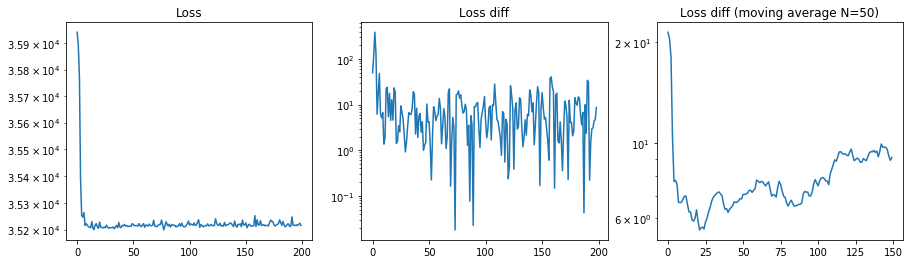

In [8]:
loss = callback.history['loss']
loss_diff = np.abs(np.diff(loss))
N = 50
loss_diff_mvavg = np.convolve(loss_diff, np.ones((N,))/N, mode='valid')

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(loss);
axs[0].set_yscale('log');
axs[0].set_title('Loss');

axs[1].plot(loss_diff);
axs[1].set_yscale('log');
axs[1].set_title('Loss diff');

axs[2].plot(loss_diff_mvavg);
axs[2].set_yscale('log');
axs[2].set_title(f'Loss diff (moving average N={N:d})');

In [9]:
plt.plot(np.max(np.abs(np.diff(coeffs_iters, axis=0)), axis=1));
plt.yscale('log');

NameError: name 'coeffs_iters' is not defined